In [ ]:
import numpy as np
import pandas as pd
import re
import os
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch
import lxml.html
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')


from lxml_html_clean import Cleaner
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1000"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrea.Bagante\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Andrea.Bagante\.virtualenvs\ai-model-omnia-QHASXsB0\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with open(".\data\super_category_id_10.json", 'r', encoding="utf8") as file:
    data = json.load(file)

In [ ]:
def combine_json(path):

    folder_path=path

    dataframes = []
    lungz = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding="utf8") as file:
                data = json.load(file)
                if "params" in data:
                    df = pd.DataFrame(data["params"]["documents"]).apply(pd.Series)
                else:
                    df = pd.DataFrame(data)

                lungh = df.shape[0]
                lungz.append(lungh)
                dataframes.append(df)

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
    else:
        print('Attenzione, nessun dataframe creato')

    if 'super_category_id' in combined_df.columns:
        combined_df['super_category_id'] = combined_df['super_category_id'].astype(int)

    return combined_df


def clean_text(text, language: str):

    assert isinstance(language, str), 'Strings only!'

    sw = stopwords.words(language)

    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)
    html=re.compile(r'<.*?>')
    #text = html.sub(r'',text) #Removing html tags

    #punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    #for p in punctuations:
    #    text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    regex_compiled = [
    r"(c\.p\.?c\.?)", ## cpc, c.p.c, etcc (codice procedura civile)
    r"(c\.c\.?)", ## codice civile
    r"([\W+])(art\.?)([\s+|\d+])", ## articolo
    r"([\W+])(artt\.?)([\s+|\d+])", ## articoli
    r"([a-zA-Z])()(\d)", ## stacca lettera da numero
    r"(\d)()([a-zA-Z])", ## stacca numero da lettera
    r"(-+)",
    r"(\u00A0{2,})",
    r"(<ul\.*[^>]*>)(.*?)(</ul>)",
    r"(<li\.*[^>]*>)(.*?)(</li>)",
    r"(<ol\.*[^>]*>)(.*?)(</ol>)",
    r"(_______________________________________________________________________________________________________)",
    r"(_{2,})",
    r"([a-z]{1})()([A-Z]{1})",
    r"(<em\.*[^>]*>)(.*?)(</em>)"
    ]
    regex_compiled_subs = [
    r"codice procedura civile",
    r"codice civile",
    r"\1articolo\3",
    r"\1articoli\3",
    r"\1 \3",
    r"\1 \3",
    r"",
    r" [campo] ",
    r"\n\2\n",
    r"\n\2\n",
    r"\n\2\n",
    r" ",
    r" ",
    r"\1 \3",
    r"\2"
    ]
    regex_compiled_spaces = [
        r"(\s{3,})", ##spazi in eccesso
    r"(\n{3,})" ## almeno un 'a capo'
    ]
    regex_compiled_spaces_subs = [
    r" ",
    r" "
    ]


    for c, s in zip(regex_compiled, regex_compiled_subs):
        text = re.compile(c).sub(s, text)
    for c, s in zip(regex_compiled_spaces, regex_compiled_spaces_subs):
        text = re.compile(c).sub(s, text)

    """metodo per rimuovere eventualmente dell'html dal testo"""
    cleaner = Cleaner(page_structure=False, links=False)
    doc_from_text = lxml.html.fromstring(text)
    doc_from_text = cleaner.clean_html(html=doc_from_text)
    text = doc_from_text.text_content()


    return text


#range(0, len(text), max_length) genera una sequenza di numeri che parte da 0 e arriva fino alla lunghezza del testo (len(text)), con incrementi di max_length
#Per ogni valore di i generato dal range, viene preso un “chunk” del testo che va dall’indice i all’indice i + max_length.
def split_and_chunk_dataframe(df, text_column, id_column, name_column, max_length):
    chunks = []
    classes = []
    names = []

    def split_text_into_chunks(text, max_length):
        return [text[i:i+max_length] for i in range(0, len(text), max_length)]

    for _, row in df.iterrows():
        text_chunks = split_text_into_chunks(row[text_column], max_length)
        chunks.extend(text_chunks)
        classes.extend([row[id_column]] * len(text_chunks))
        names.extend([row[name_column]] * len(text_chunks))

    chunked_df = pd.DataFrame({
        text_column: chunks,
        id_column: classes,
        name_column: names
    })

    return chunked_df


def balancing_df(df, id_column: str, perce:int):

    assert isinstance(id_column, str), 'Strings only!'
    assert isinstance(perce, (int, float)), 'It must be a number!'

    if isinstance(perce, int):
        perce = perce
    else:
        perce = perce*100

    label_counts = df[id_column].value_counts()

    median_count = label_counts.median()
    #mantengo solo i dati che hanno almeno il perce% in più o in meno di dati rispetto la mediana

    upper_limit = median_count * (1+(perce/100))
    lower_limit = median_count * (1-(perce/100))


    #filtro
    valid_classes = label_counts[(label_counts >= lower_limit) & (label_counts <= upper_limit)].index

    # Mantenere solo i dati delle classi valide
    cutted_df = df[df[id_column].isin(valid_classes)]

    print(label_counts[label_counts >= upper_limit].index)
    # Per le classi che eccedono il (100+perc)%, ridurre casualmente i dati
    exceeding_classes = label_counts[label_counts >= upper_limit].index

    sampled_df_list=[]

    for label in exceeding_classes:
        class_data = df[df[id_column] == label]
        sampled_data = class_data.sample(n=int(upper_limit), random_state=42)
        #print(sampled_data)
        sampled_df_list.append(sampled_data)

        sampled_df = pd.concat(sampled_df_list, ignore_index=True)
        final_df = pd.concat([cutted_df, sampled_df], ignore_index=True)

    final_df = final_df.sort_values(by='super_category_id', ascending=True)

    return final_df


def map_labels_based_on_column(df, column_name):
    unique_values = sorted(df[column_name].unique())
    mapping = {value: index for index, value in enumerate(unique_values)}
    labels_old = df[column_name].values
    labels = [mapping[x] for x in labels_old]
    return labels


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [ ]:
# Valuto se la GPU è disponibile
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

2.1.2+cu121
True
cuda:0


In [1]:
# Combino i dati contenuti nei jsons in unico dataframe
folder_path = '.\data'
combined_df = combine_json(folder_path)
#combined_df

In [ ]:
combined_df['super_category_id'].value_counts()

super_category_id
1     2385
5      758
2      375
10     300
8      300
6      262
12     122
11     109
3        7
Name: count, dtype: int64

In [ ]:
set(combined_df['super_category_id'])

{1, 2, 3, 5, 6, 8, 10, 11, 12}

In [ ]:
# Pulisco il testo
combined_df['paragraph_body'] = combined_df['paragraph_body'].apply(lambda x: clean_text(x, 'italian'))
set(combined_df['super_category_id'])

{1, 2, 3, 5, 6, 8, 10, 11, 12}

In [ ]:
# Divido i testi in chunk di massimo 512 caratteri (massimo accettato da BERT)
chunked_combined_df = split_and_chunk_dataframe(combined_df, 'paragraph_body', 'super_category_id', 'super_category_name', 512)
set(chunked_combined_df['super_category_id'])

{1, 2, 3, 5, 6, 8, 10, 11, 12}

In [ ]:
chunked_combined_df['super_category_id'].value_counts()

super_category_id
1     20950
11     6050
2      4054
5      4052
6      2209
10     1674
8      1167
12      421
3        20
Name: count, dtype: int64

In [ ]:
# Bilancio le classi: rimuovo le classi che hanno più o meno del tot% rispetto alla MEDIANA
perc = 0.7
final_df = balancing_df(chunked_combined_df, 'super_category_id', perc)
set(final_df['super_category_id'])

Index([1, 11, 2, 5], dtype='int64', name='super_category_id')


{1, 2, 5, 6, 8, 10, 11}

In [ ]:
# Mappo le label in modo tale che siano in range [0, #categorie-1]
labels = map_labels_based_on_column(final_df, 'super_category_id')

In [ ]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
# Carico il tokenizer di BERT e valuto qual è la massima lunghezza delle frasi (sarà 512)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len = 0

for sent in final_df.paragraph_body:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

c:\Users\Andrea.Bagante\.virtualenvs\ai-model-omnia-QHASXsB0\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
# Loop per creare i token e calcolare gli embeddings tramite BERT
input_ids = []
attention_masks = []

# For every text...
for text in final_df.paragraph_body:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.    '''CAMBIATO A FALSE'''
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Trasformo gli embedding, le attention mask e le labels in tensori: devono essere salvati cossì per allenare i modelli con pytorch
input_ids = torch.cat(input_ids, dim=0)
input_ids = torch.tensor(input_ids, dtype=torch.long)
attention_masks = torch.cat(attention_masks, dim=0)
attention_masks = torch.tensor(attention_masks, dtype=torch.float64)
labels = torch.tensor(labels, dtype=torch.long)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Andrea.Bagante\.virtualenvs\ai-model-omnia-QHASXsB0\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\Andrea.Bagante\AppData\Local\Temp\ipykernel_26152\4

In [ ]:
# Creo i dataset di training, validation e testing con la proporzionalità scelta. Se il testset non avesse le labels, dovrei creare un TensorDataset specifico per lui.
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = 0.7
validation_size = 0.2
testing_size = 0.1
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, validation_size, testing_size])

batch_size = 16   # è il numero di campioni utilizzati in un forward e backward pass attraverso la rete. 32 dà problemi di memoria

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),  #shuffle = True
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),  #nothing
            batch_size = batch_size
        )

# train_dataloader creato nella parte di testing

In [ ]:
# Carico il modello BertForSequenceClassification, il modello pretrained di BERT con un singolo layer finale di classificazione
model = BertForSequenceClassification.from_pretrained(    #!!!  CHECK AutoModelForSequenceClassification  !!!
    "bert-base-uncased",            # Scelgo il modello tra quelli disponibili (cambiano alcuni layer).
    num_labels = 7,                 # Numero di output del modello, da cambiare in base al numero di categorie.
    output_attentions = False,
    output_hidden_states = False,
)

# Carico il modello sulla GPU
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training and validation loops

#from tqdm.auto import tqdm

#progress_bar = tqdm(range(num_training_steps))



epochs = 4 #Solitamente se ne mettono molte e si usano i callbacks con gli early_stoppings: fermano l'allenamento quando non apprende più e sta per overfittare.

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8) # lr = 5e-5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
#scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

for epoch_i in range(0, epochs):


    # Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        # Unpack del batch di training dal dataloader, i tensori vengono copiati sulla GPU
        # il batch contiene tre tensori':
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0]
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_ids = b_input_ids.to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        loss.backward()

        # Clippa la norma del gradiente a 1.0. Serve per prevenire il problema dell'"exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   #da capire questo

        optimizer.step()
        scheduler.step()

        #progress_bar.update(1)


    # Calcolo della loss media attraverso tutti i batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Controllo quanto tempo ha impiegato questa epoca di allenamento.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # Validation

    print("")
    print("Running Validation...")

    t0 = time.time()
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    model.eval()

    for batch in validation_dataloader:
        b_input_ids = batch[0]
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_ids = b_input_ids.to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():   # non mi serve calcolare il gradiente perché il training è già stato fatto
            output= model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        logits = output.logits
        logits = logits.detach().cpu().numpy()  # distacco dal batch i risultati e li salvo sulla CPU
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids) # salvo l'accuracy del batch

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader) # media delle accuracy (accuracy di ogni batch/#tot dei batch)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    # Se l'accuracy dell'epoca attuale è migliore, salvo lo state_dict del modello (salvo i "parametri" da utilizzare nel test)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model.state_dict(), './models/bert_model.pth')
        best_eval_accuracy = avg_val_accuracy

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.51
  Training epcoh took: 0:02:57

Running Validation...
  Accuracy: 0.94

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.16
  Training epcoh took: 0:02:59

Running Validation...
  Accuracy: 0.95

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.10
  Training epcoh took: 0:02:59

Running Validation...
  Accuracy: 0.97

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.07
  Training epcoh took: 0:02:59

Running Validation...
  Accuracy: 0.97

Training complete!
Total training took 0:13:05 (h:mm:ss)


In [ ]:
# Testing

# Carico lo state_dict del modello
model.load_state_dict(torch.load('./models/bert_model.pth'))

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

predictions = []

for batch in test_dataloader:
        b_input_ids = batch[0]
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_ids = b_input_ids.to(device)
        b_input_mask = batch[1].to(device)

        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

test_label = test_dataset[:][2].to('cpu').numpy()   #si può fare in altro modo, ad es come nel validation set
test_pred = predictions


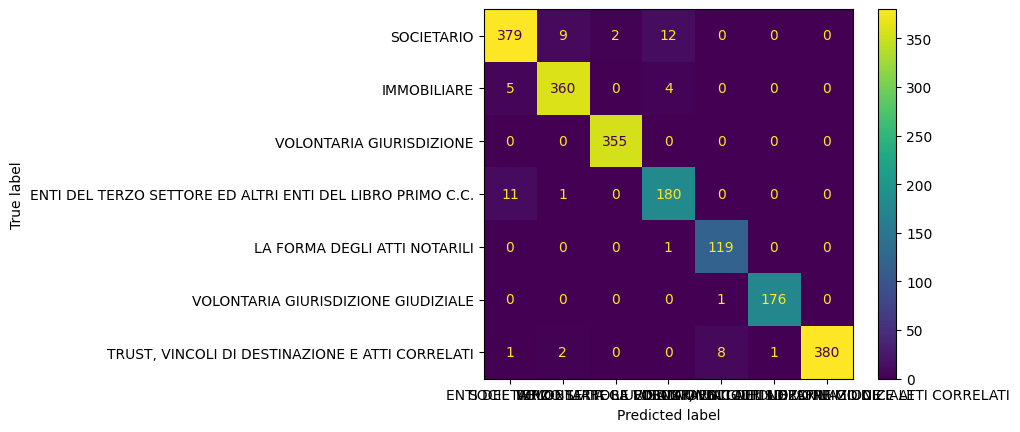

In [ ]:
# Mostro alcune metriche

#test_accuracy = flat_accuracy(test_pred, test_label)
cm = confusion_matrix(test_label, test_pred, labels=labels.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_df.super_category_name.unique())
disp.plot()
plt.show()

In [ ]:
print(classification_report(test_label, test_pred, target_names=final_df.super_category_name.unique()))

                                                           precision    recall  f1-score   support

                                               SOCIETARIO       0.96      0.94      0.95       402
                                              IMMOBILIARE       0.97      0.98      0.97       369
                                 VOLONTARIA GIURISDIZIONE       0.99      1.00      1.00       355
ENTI DEL TERZO SETTORE ED ALTRI ENTI DEL LIBRO PRIMO C.C.       0.91      0.94      0.93       192
                             LA FORMA DEGLI ATTI NOTARILI       0.93      0.99      0.96       120
                      VOLONTARIA GIURISDIZIONE GIUDIZIALE       0.99      0.99      0.99       177
          TRUST, VINCOLI DI DESTINAZIONE E ATTI CORRELATI       1.00      0.97      0.98       392

                                                 accuracy                           0.97      2007
                                                macro avg       0.97      0.97      0.97      2007
        